In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score

In [6]:
df = pd.read_csv("course_lead_scoring.csv")

In [7]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [8]:
# Check for missing values
missing = df.isnull().sum()
print(missing)

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64


In [9]:
# Identify categorical and numerical columns (excluding target)
target_col = 'converted'
cat_cols = df.select_dtypes(include='object').columns.drop(target_col, errors='ignore')
num_cols = df.select_dtypes(include='number').columns.drop(target_col, errors='ignore')

# Fill missing values
df[cat_cols] = df[cat_cols].fillna('NA')
df[num_cols] = df[num_cols].fillna(0.0)

In [10]:
# Split into train/validation/test (60/20/20)
df_full = df.copy()
df_temp, df_test = train_test_split(df_full, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_temp, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.20

print('Train shape:', df_train.shape)
print('Validation shape:', df_val.shape)
print('Test shape:', df_test.shape)

Train shape: (876, 9)
Validation shape: (293, 9)
Test shape: (293, 9)


In [11]:
from sklearn.metrics import roc_auc_score

num_vars = ["lead_score", "number_of_courses_viewed", "interaction_count", "annual_income"]
target = "converted"
aucs = {}

for var in num_vars:
    pred = df_train[var].values
    y = df_train[target].values
    auc = roc_auc_score(y, pred)
    if auc < 0.5:
        auc = roc_auc_score(y, -pred)
    aucs[var] = auc

for var, auc in sorted(aucs.items(), key=lambda x: x[1], reverse=True):
    print(f"{var}: AUC={auc:.4f}")

number_of_courses_viewed: AUC=0.7636
interaction_count: AUC=0.7383
lead_score: AUC=0.6145
annual_income: AUC=0.5520


In [13]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

feature_cols = [col for col in df_train.columns if col != 'converted']
X_train = df_train[feature_cols].to_dict(orient='records')
X_val = df_val[feature_cols].to_dict(orient='records')
y_train = df_train['converted'].values
y_val = df_val['converted'].values

dv = DictVectorizer(sparse=False)
X_train_enc = dv.fit_transform(X_train)
X_val_enc = dv.transform(X_val)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_enc, y_train)

val_pred = model.predict_proba(X_val_enc)[:, 1]

from sklearn.metrics import roc_auc_score
val_auc = roc_auc_score(y_val, val_pred)
print(f'Validation ROC AUC: {val_auc:.3f}')

Validation ROC AUC: 0.817


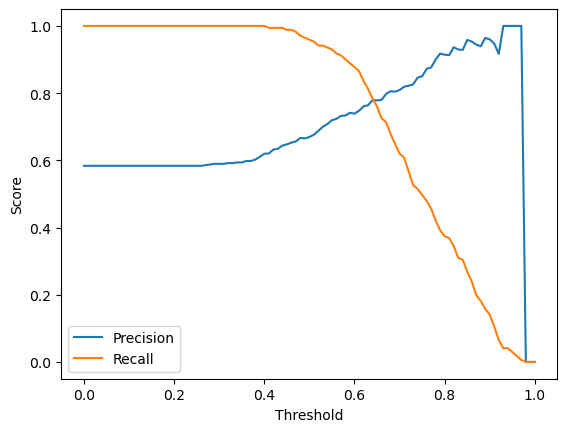

Precision and recall curves intersect at threshold: 0.980


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    preds_bin = (val_pred >= t).astype(int)
    precisions.append(precision_score(y_val, preds_bin, zero_division=0))
    recalls.append(recall_score(y_val, preds_bin, zero_division=0))

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

precision_recall_diffs = np.abs(np.array(precisions) - np.array(recalls))
intersect_idx = np.argmin(precision_recall_diffs)
intersect_threshold = thresholds[intersect_idx]
print(f'Precision and recall curves intersect at threshold: {intersect_threshold:.3f}')

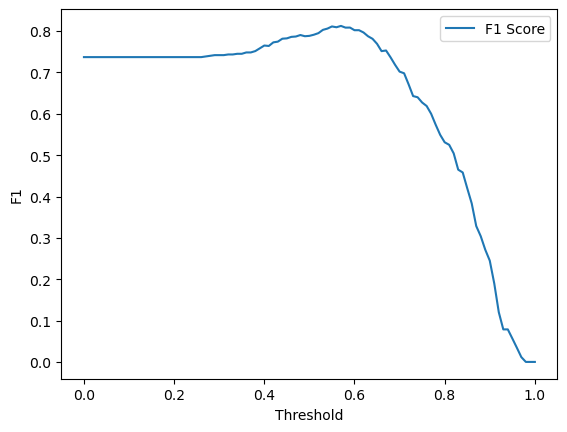

F1 score is maximal at threshold: 0.57


In [15]:
f1_scores = []
for p, r in zip(precisions, recalls):
    f1 = 0 if (p+r)==0 else 2 * p * r / (p + r)
    f1_scores.append(f1)

plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1')
plt.legend()
plt.show()

max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
print(f'F1 score is maximal at threshold: {max_f1_threshold:.2f}')

In [16]:
from sklearn.model_selection import KFold

df_full_train = df_full.copy()  # Use full train (train+val, not test here)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train_cv = df_full_train.iloc[train_idx]
    df_val_cv = df_full_train.iloc[val_idx]

    X_train_cv = df_train_cv[feature_cols].to_dict(orient='records')
    X_val_cv = df_val_cv[feature_cols].to_dict(orient='records')
    y_train_cv = df_train_cv['converted'].values
    y_val_cv = df_val_cv['converted'].values

    dv_cv = DictVectorizer(sparse=False)
    X_train_cv_enc = dv_cv.fit_transform(X_train_cv)
    X_val_cv_enc = dv_cv.transform(X_val_cv)

    model_cv = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_cv.fit(X_train_cv_enc, y_train_cv)

    val_pred_cv = model_cv.predict_proba(X_val_cv_enc)[:, 1]
    roc_auc_cv = roc_auc_score(y_val_cv, val_pred_cv)
    scores.append(roc_auc_cv)

mean_score = np.mean(scores)
std_score = np.std(scores)
print(f"Mean AUC: {mean_score:.3f} | Std: {std_score:.3f}")

Mean AUC: 0.821 | Std: 0.029


In [17]:
C_list = [0.000001, 0.001, 1]
cv_results = {}

for C in C_list:
    scores = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_cv = df_full_train.iloc[train_idx]
        df_val_cv = df_full_train.iloc[val_idx]

        X_train_cv = df_train_cv[feature_cols].to_dict(orient='records')
        X_val_cv = df_val_cv[feature_cols].to_dict(orient='records')
        y_train_cv = df_train_cv['converted'].values
        y_val_cv = df_val_cv['converted'].values

        dv_cv = DictVectorizer(sparse=False)
        X_train_cv_enc = dv_cv.fit_transform(X_train_cv)
        X_val_cv_enc = dv_cv.transform(X_val_cv)

        model_cv = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_cv.fit(X_train_cv_enc, y_train_cv)
        val_pred_cv = model_cv.predict_proba(X_val_cv_enc)[:, 1]
        roc_auc_cv = roc_auc_score(y_val_cv, val_pred_cv)
        scores.append(roc_auc_cv)

    mean_score = np.mean(scores)
    std_score = np.std(scores)
    cv_results[C] = (mean_score, std_score)
    print(f"C={C} | Mean AUC: {mean_score:.3f} | Std: {std_score:.3f}")

C=1e-06 | Mean AUC: 0.549 | Std: 0.030
C=0.001 | Mean AUC: 0.862 | Std: 0.024
C=1 | Mean AUC: 0.821 | Std: 0.029
